Each task that is proposed to be completed as part of the homework has a declared "price" in points. The maximum possible amount is 10 points, and together with the bonus assignment - 12 points. It is not necessary to complete all the tasks, only a part can be done. Most of the points expect you to write working Python code; sometimes you will need to write comments - for example, to compare several approaches to solve the same problem. Also you can add more cells for your convenience if you need.

This homework focuses on clustering. We will work with images of handwritten digits, learn how to cluster them using two different methods (hierarchical clustering and the 𝐾-means algorithm), evaluate the quality of the partition and choose the optimal number of clusters, as well as visualize intermediate results.

## 1. Loading data
The data we will be working with is available in the scikit-learn library (`sklearn` module) in the `datasets` submodule via the `load_digits` function. The data contains 1,797 observations, each of which is 8×8 pixel image of a handwritten digit from 0 to 9. This is about the same amount of each digit (about 180).

For convenience, every image expands to a 64 (8×8) row, so entire numpy array is 1797×64. The color intensity in each pixel is encoded with an integer from 0 to 16.

In addition to images, their labels are also known. In this task, we will assume that the labels (as well as their amount) are unknown and try to group the data in such a way that the resulting clusters 'better match' the original ones. Possible options for determining the 'better match' are presented later.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

**(0.25 points)** Load the images into `X` variable, and their labels into `y` variable.

In [2]:
from sklearn import datasets

In [3]:
X, y = datasets.load_digits(n_class=10, return_X_y=True)

In [4]:
assert X.shape == (1797, 64)
assert y.shape == (1797,)

**(0.5 points)** Visualize the first 10 images.

- Arrange images on a grid rather than in a row. You may need the `subplot` and `imshow` functions from the `pyplot` module in the `matplotlib` library.
- You will also need to reshape the images to 8×8.
- Remove ticks and labels from both axes. The `xticks` and `yticks` functions or the `tick_params` function from `pyplot` can help you with this.
- Make the output good sized with the `figure` function from `pyplot`.

- DONE Arrange images on a grid rather than in a row. You may need the **subplot** and **imshow** functions from the pyplot module in the matplotlib library.
- DONE You will also need to reshape the images to 8×8.
- DONE Remove ticks and labels from both axes. The xticks and yticks functions or the tick_params function from pyplot can help you with this.
- Make the output good sized with the figure function from pyplot.

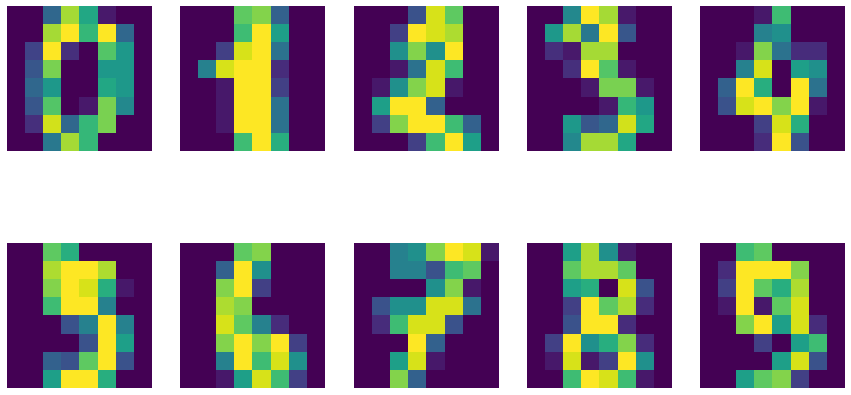

In [5]:

f, axes = plt.subplots(nrows=2, ncols=5, figsize=(15,8))
# f, axes = plt.subplots(nrows=2, ncols=5)
for ax, image, label in zip(axes.flatten(), X, y):
    ax.set_axis_off()
    ax.imshow(image.reshape((8, 8)))
plt.show();

## 2. Clustering and quality evaluation

**(2 points)** Implement the the KMeans algorithm. Use objective function $L = \sum_{i=1}^{n}|x_{i}-Z_{A(x_{i})}|^{2}$, where $Z_{A(x_{i})}$ is the center of the cluster corresponding to $x_{i}$ object.

In [6]:
from sklearn.exceptions import NotFittedError
from sklearn.metrics import pairwise_distances
from numpy.random import RandomState
from math import sqrt

In [7]:
class CustomKMeans:
    def __init__(self, n_clusters=2, max_iter=30, n_init=10, random_state=42):
        '''K-Means clustering.
        
        Args:
            n_clusters: int, default=2
                The number of clusters to be formed is also 
                the number of centroids to generate. 
            max_iter: int, default=300
                Maximum number of iterations of the k-means algorithm for a
                single run.
            n_init: int, default=10
                Number of time the k-means algorithm will be run with different
                centroid seeds. The final results will be the best output of
                n_init consecutive runs in terms of objective function.
            random_state: int, default=42
                Random state.
        '''
        self.n_clusters = n_clusters
        self.n_init = n_init
        self.max_iter = max_iter
        self.random_state = RandomState(seed=random_state)
        self.objective_value = None
        self.obj_hist = []
        
    def calculate_distances_to_centroids(self, X, cluster_centers):
        """
        Returns (n, c) matrix where the element at position (i, j) 
        is the distance from i-th object to j-th centroid."""
        # <your code>
        #return np.array([[sqrt(sum((i-j)**2)) for j in cluster_centers] for i in X])
        return pairwise_distances(X, cluster_centers)
    
    def update_centroids(self, X, nearest_clusters):
        """
        Returns numpy array of shape (n_clusters, n_features) - 
        new clusters that are found by averaging objects belonging 
        to the corresponding cluster."""
        # <your code>
        distance_matrix = self.calculate_distances_to_centroids(X, nearest_clusters)
        y = np.zeros(X.shape[0])
        y[:] = np.nan
        for i in range(nearest_clusters.shape[0]):
            mask = distance_matrix[:,i] == distance_matrix.min(axis=1)
            nearest_clusters[i] = X[mask].mean(axis=0)
            y[mask] = i
        return nearest_clusters, y.astype(int)
    
    def objective(self, dist_matrix, y):
#         print("DM ", dist_matrix.shape)
#         print("y ", y.shape)
        a = dist_matrix**2
#         print(a[np.arange(a.shape[0]),y].sum())
        return a[np.arange(a.shape[0]),y].sum()
            
        
    def fit(self, X):
        """Fit the model.
        
        Args:
            X: numpy array of shape (n_samples, n_features)
        """
        
        assert X.shape[0] >= self.n_clusters
        
        #init centroids
#         idx = np.random.randint(X.shape[0], size=self.n_clusters) 
        for j in range(self.n_init):
            idx = self.random_state.randint(X.shape[0], size=self.n_clusters)
            cluster_centers = X[idx]
#         print("MAX_ITER ", self.max_iter)
            for i in range(self.max_iter): 
                cluster_centers, y = self.update_centroids(X, cluster_centers)

                dist_matrix = self.calculate_distances_to_centroids(X, cluster_centers)
                objective = self.objective(dist_matrix, y)
    #             print(objective)
                if (self.objective_value == None) or  (self.objective_value > objective):
                    self.classes_ = y
                    self.cluster_centers_ = cluster_centers
                    self.objective_value = objective
                    self.obj_hist.append(objective)
        
        return self
            
    
    def predict(self, X):
        """Predict classes.
        
        Args:
            X: numpy array of shape (n_samples, n_features)
        Returns:
            y: numpy array of shape (n_samples,)
                Vector containing predicted cluster labels.
        """
        if hasattr(self, 'cluster_centers_'):
            # <your code>
            dist_matrix = self.calculate_distances_to_centroids(X, self.cluster_centers_)
            y = np.zeros(self.cluster_centers_)
            y[:] = np.nan
            for i in range(self.cluster_centers_.size):
                mask = dist_matrix[:,i] == dist_matrix.min(axis=1)
                y[mask] = i
            return y
        else: 
            raise NotFittedError("CustomKMeans instance is not fitted yet")

**(1 points)** Get the `X` array partition into 10 clusters. Visualize the centers of clusters.
- We will assume that the center of the cluster is average value of all observations belonging to the cluster.
- The cluster centers should have the same shape as our observations (64). So you have to average the points across the rows.

In [8]:
model = CustomKMeans(n_clusters=10)
model.fit(X)
custom_kmeans_labels = model.classes_
assert custom_kmeans_labels.shape == (1797,)

In [9]:
clusters_centers = model.cluster_centers_

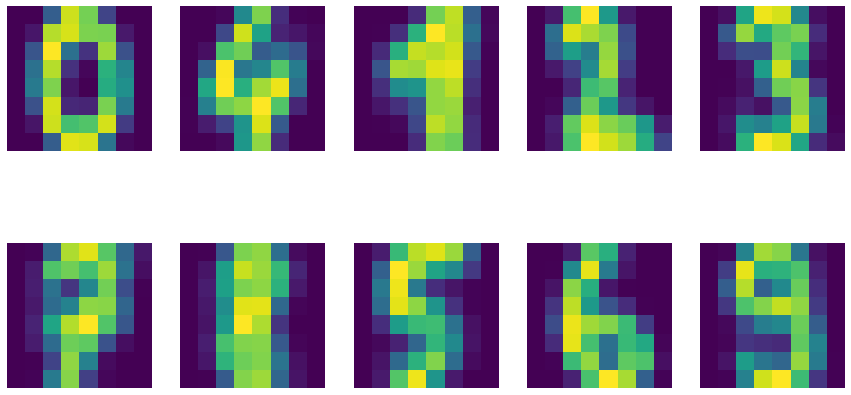

In [10]:
f, axes = plt.subplots(nrows=2, ncols=5, figsize=(15,8))
for ax, image in zip(axes.flatten(), clusters_centers):
    ax.set_axis_off()
    ax.imshow(image.reshape((8, 8)))
plt.show();

<AxesSubplot:>

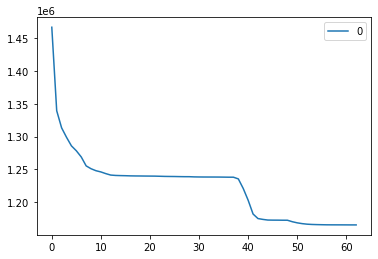

In [11]:
pd.DataFrame(model.obj_hist).plot()

**(0.5 points)** Experiment with `max_iter` and `n_init` parameters. Look at the range of values of the objective function, it's best values, at what parameters and how often they are achieved.

Последнее значение целевой функции:  1165180.5352550172
Сколько раз обновлялись значения центров кластеров:  63


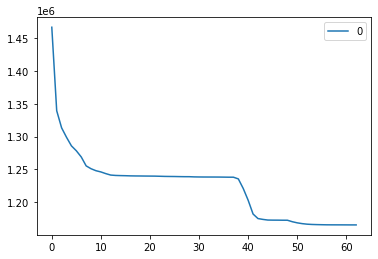

In [12]:
model = CustomKMeans(n_clusters=10, max_iter=30)
model.fit(X)
pd.DataFrame(model.obj_hist).plot()
print("Последнее значение целевой функции: ", model.objective_value)
print("Сколько раз обновлялись значения центров кластеров: ", len(model.obj_hist))

Последнее значение целевой функции:  1165180.5352550172
Сколько раз обновлялись значения центров кластеров:  63


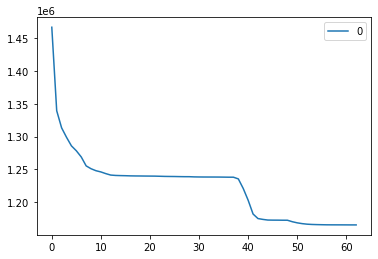

In [13]:
model = CustomKMeans(n_clusters=10, max_iter=50)
model.fit(X)
pd.DataFrame(model.obj_hist).plot()
print("Последнее значение целевой функции: ", model.objective_value)
print("Сколько раз обновлялись значения центров кластеров: ", len(model.obj_hist))

Последнее значение целевой функции:  1165180.5352550172
Сколько раз обновлялись значения центров кластеров:  63


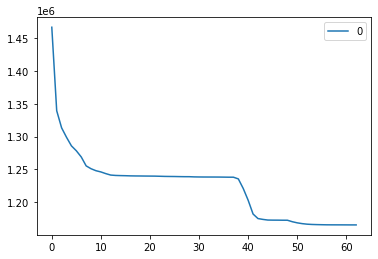

In [14]:
model = CustomKMeans(n_clusters=10, max_iter=150)
model.fit(X)
pd.DataFrame(model.obj_hist).plot()
print("Последнее значение целевой функции: ", model.objective_value)
print("Сколько раз обновлялись значения центров кластеров: ", len(model.obj_hist))

**Видим что увеличение числа итераций не улучшает результат, и число реальных обновлений значений центров кластеров остается постоянным, равным 29. (Такие результаты получены при завиксированном random_state)**

Последнее значение целевой функции:  1165180.5352550172
Сколько раз обновлялись значения центров кластеров:  63


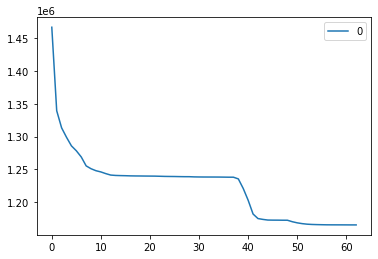

In [15]:
model = CustomKMeans(n_clusters=10, max_iter=150, n_init=10)
model.fit(X)
pd.DataFrame(model.obj_hist).plot()
print("Последнее значение целевой функции: ", model.objective_value)
print("Сколько раз обновлялись значения центров кластеров: ", len(model.obj_hist))

Последнее значение целевой функции:  1165177.9564240165
Сколько раз обновлялись значения центров кластеров:  64


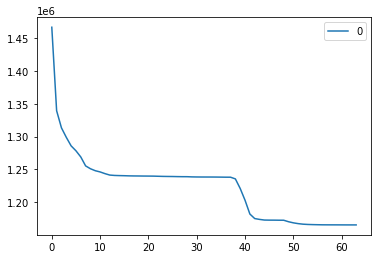

In [16]:
model = CustomKMeans(n_clusters=10, max_iter=150, n_init=30)
model.fit(X)
pd.DataFrame(model.obj_hist).plot()
print("Последнее значение целевой функции: ", model.objective_value)
print("Сколько раз обновлялись значения центров кластеров: ", len(model.obj_hist))

Последнее значение целевой функции:  1165138.0661156569
Сколько раз обновлялись значения центров кластеров:  65


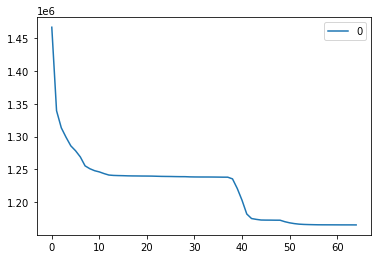

In [17]:
model = CustomKMeans(n_clusters=10, max_iter=150, n_init=50)
model.fit(X)
pd.DataFrame(model.obj_hist).plot()
print("Последнее значение целевой функции: ", model.objective_value)
print("Сколько раз обновлялись значения центров кластеров: ", len(model.obj_hist))

Последнее значение целевой функции:  1165138.0661156569
Сколько раз обновлялись значения центров кластеров:  65


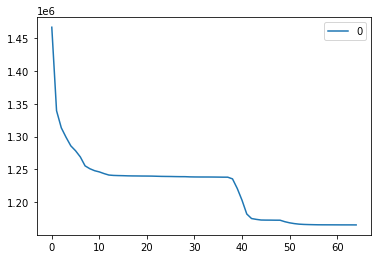

In [18]:
model = CustomKMeans(n_clusters=10, max_iter=100, n_init=100)
model.fit(X)
pd.DataFrame(model.obj_hist).plot()
print("Последнее значение целевой функции: ", model.objective_value)
print("Сколько раз обновлялись значения центров кластеров: ", len(model.obj_hist))

**Такие же результаты дало увеличение числа инициализаций**

In [19]:
from sklearn.model_selection import GridSearchCV
from sklearn.cluster import KMeans

Now we will use two popular algorithms: hierarchical clustering and $K$-means clustering. These and other algorithms are available in the `scikit-learn` module in the `cluster` submodule. Hierarchical clustering is called `AgglomerativeClustering`, and the $K$-means method is called `KMeans`.

**(0.5 points)** Use each of the two methods: hierarchical clustering and KMeans. Get the `X` array partition into 10 clusters.

- Note that `AgglomerativeClustering` does not have a `predict` method, so you can either use the `fit_predict` method or use the `fit` method and then look at the `labels_` attribute of the class instance.
- Kmeans performs multiple runs (default 10) with random centers and then returns the best partition in terms of average distance within the clusters. You can increase the number of runs to improve the quality of predictions in the `i_init` parameter.

In [20]:
from sklearn.cluster import KMeans

In [21]:
from sklearn.cluster import AgglomerativeClustering

In [22]:
agc = AgglomerativeClustering(n_clusters=10)
agc.fit(X)
hierarchical_labels = agc.labels_

kmean = KMeans(n_clusters=10)
kmean.fit(X)
kmeans_labels = kmean.labels_
kmeans_centers = model.cluster_centers_

In [23]:
assert hierarchical_labels.shape == (1797,)
assert kmeans_labels.shape == (1797,)

In [24]:
agc_clusters = []
for i in range(10):
    agc_clusters.append((X[agc.labels_ == i]).mean(axis=0))
agc_clusters = np.array(agc_clusters)

**(0.5 points)** Visualize the centers of clusters obtained by both methods.

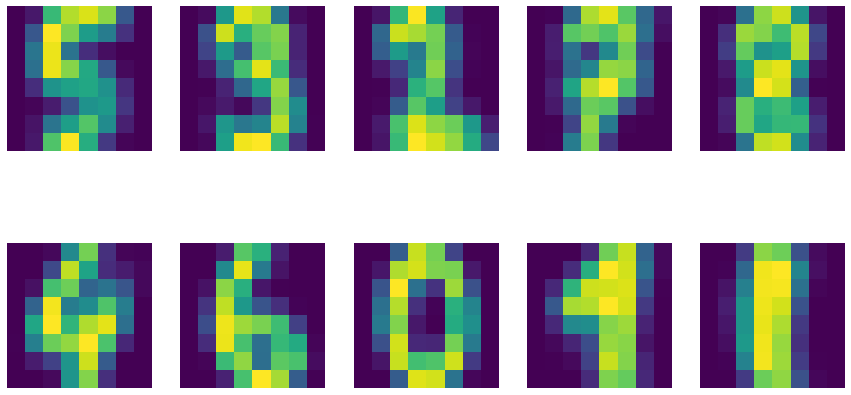

In [25]:
f, axes = plt.subplots(nrows=2, ncols=5, figsize=(15,8))
for ax, image in zip(axes.flatten(), agc_clusters):
    ax.set_axis_off()
    ax.imshow(image.reshape((8, 8)))
plt.show();

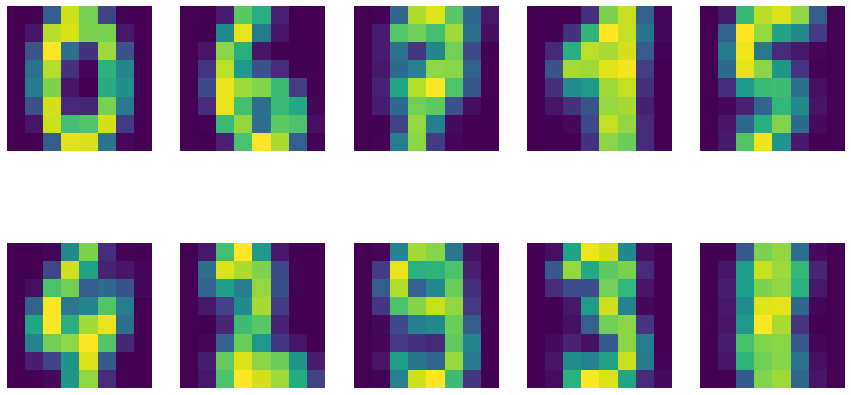

In [26]:
f, axes = plt.subplots(nrows=2, ncols=5, figsize=(15,8))
for ax, image in zip(axes.flatten(), kmeans_centers):
    ax.set_axis_off()
    ax.imshow(image.reshape((8, 8)))
plt.show();

In a situation where the true number of classes is unknown, we can select it by maximazing some metric.

When we can set some distance function between our observations, we can consider the `silhouette` distance as a function of measuring the quality of the clustering. Let's show how it is calculated:

Let $X$ – set of observations, $M \subset X$ – one of the clusters obtained as a result of clustering process, $\rho$ – some metric on $X$. Let's choose one observation $x \in M$. Denote $a(x)$ as the average distance from $x$ to  $x'$ points from the same cluster:
$$
a(x) = \frac{1}{|M| - 1} \sum_{x' \in M,\, x' \ne x} \rho(x,\, x')
$$

Denote $b(x)$ as minimun of average distances from $x$ to $x''$ from some other cluster $N$:
$$
b(x) = \min_{N \ne M} \frac{1}{|N|} \sum_{x'' \in N} \rho(x,\, x'')
$$

The silhouette is difference between a(x) and b(x), normalized to $[-1, \, 1]$ and averaged over all observations:
$$
\frac{1}{|X|} \sum_{x \in X} \frac{b(x) - a(x)}{\max(a(x),\, b(x))}
$$

The implementation of this metric in the `scikit-learn` is the `silhouette_score` function from the `metrics` submidule.

**(0.75 point)** For each $K$ between 2 and 20 inclusive, partition of the array $X$ into $K$ clusters using both methods. Calculate the silhouette score and visualize it for both methods on the same plot ($K$ on the $x$ axis and silhouette score on the $y$ axis). Sign the axes and make a legend.

In [27]:
from sklearn.metrics import silhouette_score
result_km = []
km_labels = []
for i in range(2, 21):
    kmean = KMeans(n_clusters=i)
    kmean.fit(X)
    km_labels.append(kmean.labels_)
    score = silhouette_score(X, kmean.labels_, metric='euclidean')
    result_km.append(score)

In [28]:
result_agc = []
agc_labels = []
for i in range(2, 21):
    agc = AgglomerativeClustering(n_clusters=i)
    agc.fit(X)
    agc_labels.append(agc.labels_)
    score = silhouette_score(X, agc.labels_, metric='euclidean')
    result_agc.append(score)

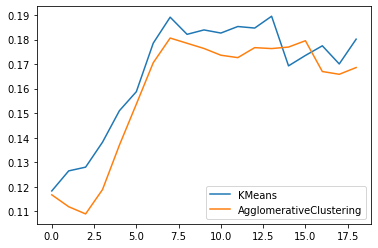

In [29]:
df = pd.DataFrame()
df["KMeans"] = result_km
df["AgglomerativeClustering"] = result_agc
df.plot();

When we know the true clustering labels, the clustering result can be compared to them using measures such as `homogeneity`, `completeness` and their harmonic mean - $V$-score. The definitions of these quantities are rather bulky and are based on the [entropy of the probability distribution](https://ru.wikipedia.org/wiki/Информационная_энтропия). Details are given in [this article](http://aclweb.org/anthology/D/D07/D07-1043.pdf). In practice, it's enough to know that `homogeneity`, `completeness` and $V$-score are in the range from 0 and 1, and the more, the better.

Since we know what digit each image is (`y` array), we can compare the clustering results to it using the measures listed above.

**(0.5 points)** Repeat the previous task using $V$-measure instead of silhouette.

In [30]:
from sklearn.metrics import v_measure_score

<AxesSubplot:>

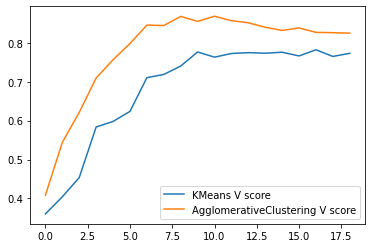

In [31]:
km_V = [v_measure_score(y, km_labels[i]) for i in range(len(km_labels))]
agc_V = [v_measure_score(y, agc_labels[i]) for i in range(len(agc_labels))]
df = pd.DataFrame()
df["KMeans V score"] = km_V
df["AgglomerativeClustering V score"] = agc_V
df.plot()

## 3. Feature space dimensionality reduction

In some cases, especially when there are a large number of features, when not all of them are informative, and some of them are correlated, it can be useful to reduce the dimension of the feature space. This mean that instead of $d$ original features, we will go to $d'\ll d$ new ones. And if earlier our data were presented in the form of an $n×d$ matrix, then it will presented as a $n×d'$.

There are two popular dimensionality reduction approaches:
- select new features from existing features;
- extract the new features by transforming old ones, for example, by making $d'$ different linear combinations of columns of an $n×d$ matrix.

One widely used dimensionality reduction technique is the Singular Value Decomposition (SVD). This method allows you to construct any number $d'\leq d$ of new features in such a way that they are the most informative (in some sense).

The `scikit-learn` module has several implementations of singular value decomposition. We will use the `TruncatedSVD` class from the `decomposition` submodule.

**Note:** The singular value decomposition of the matrix $M$ is usually written as $M=U \Sigma V^{*}$. `TruncatedSVD`, in turn, returns only the $d'$ first columns of the matrix $U$.

**(0.75 point)** Perform a singular value decomposition of the $X$ matrix, leaving 2, 5, 10, 20 features. In each case, perform hierarchical clustering and $K$-Means clustering (take the number of clusters equal to 10). Calculate the silhouette and $V$-score and compare them to corresponding values obtained from the original data.

**Note**: It is not valid to compare the silhouette calculated with different metrics. Even if we use the same metric function when calculating the distance between points in the data, after applying dimensionality reduction or other data transformations, we will (not always) get different silhouette scores. Therefore, after training the clustering algorithm, to compare the result of clustering, you need to calculate the silhouette on the original data.

In [32]:
from sklearn.decomposition import TruncatedSVD

In [33]:
svd = TruncatedSVD(n_components=5, n_iter=7, random_state=42)
svd.fit(X)

TruncatedSVD(n_components=5, n_iter=7, random_state=42)

In [34]:
# for i in [2,5,10,20]:
i=2
svd = svd TruncatedSVD(n_components=i, random_state=42)

svd.fit(X)
X_red = svd_transform(X)

agc
kmeans

silhouette
v_score

array([2193.11933683,  566.99677184,  542.00493276,  504.1516975 ,
        425.59296526])

Another popular dimensionality reduction approach that is useful for working with images is t-distributed stochastic neighbor embeddings, abbreviated `tSNE`. Unlike singular value decomposition, this it is non-linear transformation. It's main idea is to map points from a space of dimension `d` to another space of dimension 2 or 3 in such a way that the distances between points are mostly preserved. Mathematical details can be found, for example, [here](https://en.wikipedia.org/wiki/T-distributed_stochastic_neighbor_embedding).

The implementation of `tSNE` in the `scikit-learn` library is the `TSNE` class in the `manifold` submodule.

**Note:** In recent years [UMAP](https://github.com/lmcinnes/umap) is often used istead of `tSNE`. It is a faster algorithm with similar properties. We don't ask you to use `UMAP` because it requires you to install another dependency, the `umap-learn` library. Those who wish can perform the following task using `UMAP`.

**(0.5 points)** Perform a tSNE-transform of the `X` matrix, leaving 2 features. Visualize the obtained data in the form of a scatter plot form: the first feature on the horizontal axis, and the second one the vertical axis. Color the points according to the digits they belong to.

- The `c` parameter in the plt.scatter function is responsible for the color of the points. Pass the true labels to it.

**(0.5 points)** From the data transformed using the tSNE, perform hierarchical clustering and $K$-means clustering (take the number of clusters equal to 10). Calculate the silhouette and the $V$-score and compare them to corresponding values obtained from the original data.

**(0.25 points)** Choose the best partition (in terms of silhouette or $V$-score) and visualize the centers of clusters with images. Did you managed to make each digit correspond to one center of the cluster?

## 4. Results and bonus part

Write in free form what conclusions you made after completing this assignment. Answer the following questions:

**(0.5 points)** Which algorithm gives more meaningful results - hierarchical clustering or $K$- means clustering. Does it depend on the algorithm settings or on the quality evaluation method?

**(0.5 points)** Imagine the situation where after hierarchical clustering, you need to cluster new data in the same way without retraining the model. Suggest a method how you will do it and how you will measure the quality of clustering of new data.

**(0.5 points)** Does dimensionality reduction improve clustering results?

**(0.5 points)** How to evaluate the quality of dimensional reduction? Suggest at least 2 options.

**(Bonus 2 points)** Load the [MNIST Handwritten Digits](http://yann.lecun.com/exdb/mnist) dataset. You can also do it with `scikit-learn` as explained [here](https://stackoverflow.com/a/60450028). Explore the data and try to cluster it using different approaches. Compare results of these approaches using the silhouette and the $V$-score.